In [15]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if ".txt" in filename:
            print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [16]:
# https://github.com/emanhamed/Houses-dataset

## Import Statement

In [166]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt

from collections.abc import Sequence
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv2D,MaxPooling2D, Flatten
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [167]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt

from collections.abc import Sequence
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv2D,MaxPooling2D, Flatten
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [168]:
import seaborn as sns
import csv
import numpy as np
%matplotlib inline

import cv2
import glob
from IPython.display import Image

In [169]:
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)
    
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd

def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)
    
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)
    
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)

def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

## Data Preprocessing

### Import Data

In [175]:
# filename_read = '/kaggle/input/home-data/Houses Dataset/HousesInfo.txt' 
filename_read = './Houses Dataset/HousesInfo.txt'

In [176]:
cols=["Bedrooms","Bathrooms","area","zipcode","price"]
df = pd.read_csv(filename_read , sep=" ", header=None , names=cols)

In [177]:
df.head()

,Bedrooms,Bathrooms,area,zipcode,price
0,4,4.0,4053,85255,869500
1,4,3.0,3343,36372,865200
2,3,4.0,3923,85266,889000
3,5,5.0,4022,85262,910000
4,3,4.0,4116,85266,971226


In [178]:
df.shape

(535, 5)

### Handle Images dataset

In [179]:
# filepath = "/kaggle/input/home-data/Houses Dataset/"
filepath = './Houses Dataset/'

In [180]:
## Bathroom.jpg
new_images=[]
for number in range(1, df.shape[0] + 1):
    for path in glob.glob(filepath + str(number) + "_bathroom.jpg"):
        if os.path.isfile(path):
            new_images.append(path) 

In [181]:
new_images[:5]

['./Houses Dataset/1_bathroom.jpg',
 './Houses Dataset/2_bathroom.jpg',
 './Houses Dataset/3_bathroom.jpg',
 './Houses Dataset/4_bathroom.jpg',
 './Houses Dataset/5_bathroom.jpg']

In [182]:
img= pd.DataFrame(new_images,columns = ['bathroom_img'])

In [183]:
## bedroom images
bedroom_images = []
for number in range(1, df.shape[0] + 1):
    for path in glob.glob(filepath + str(number)+ "_bedroom.jpg"):
        if os.path.isfile(path):
            bedroom_images.append(path) 

In [184]:
img['bedroom_img']=bedroom_images

In [185]:
frontal_images = []
for number in range(1, df.shape[0] + 1):
    for path in glob.glob(filepath + str(number) + "_frontal.jpg"):
        if os.path.isfile(path):
            frontal_images.append(path) 

In [186]:
img['frontal_img']=frontal_images

In [187]:
kitchen_images = []
for number in range(1, df.shape[0] + 1):
    for path in glob.glob(filepath + str(number) + "_kitchen.jpg"):
        if os.path.isfile(path):
            kitchen_images.append(path) 

In [188]:
img['kitchen_img']=kitchen_images

In [190]:
img.head()

# Maybe consider removing outliers here?

,bathroom_img,bedroom_img,frontal_img,kitchen_img
0,./Houses Dataset/1_bathroom.jpg,./Houses Dataset/1_bedroom.jpg,./Houses Dataset/1_frontal.jpg,./Houses Dataset/1_kitchen.jpg
1,./Houses Dataset/2_bathroom.jpg,./Houses Dataset/2_bedroom.jpg,./Houses Dataset/2_frontal.jpg,./Houses Dataset/2_kitchen.jpg
2,./Houses Dataset/3_bathroom.jpg,./Houses Dataset/3_bedroom.jpg,./Houses Dataset/3_frontal.jpg,./Houses Dataset/3_kitchen.jpg
3,./Houses Dataset/4_bathroom.jpg,./Houses Dataset/4_bedroom.jpg,./Houses Dataset/4_frontal.jpg,./Houses Dataset/4_kitchen.jpg
4,./Houses Dataset/5_bathroom.jpg,./Houses Dataset/5_bedroom.jpg,./Houses Dataset/5_frontal.jpg,./Houses Dataset/5_kitchen.jpg


### Describe the price distribution and handle outliers

In [289]:
price_summary = df['price'].describe()

price_summary

count    5.350000e+02
mean     5.893628e+05
std      5.090261e+05
min      2.200000e+04
25%      2.492000e+05
50%      5.290000e+05
75%      7.285000e+05
max      5.858000e+06
Name: price, dtype: float64

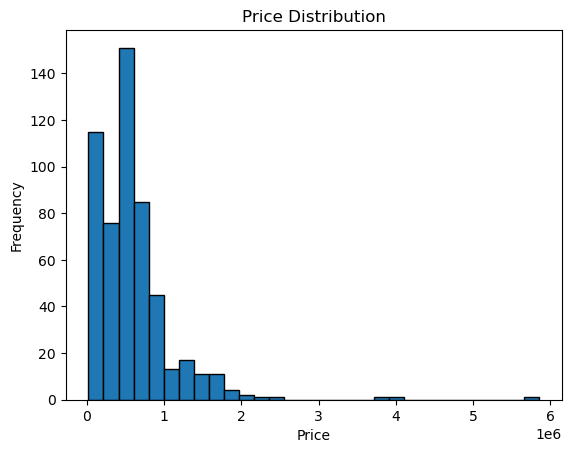

In [290]:
# Print out the spread of prices using matplotlib
# Assuming df['prices'] contains your price data
plt.hist(df['price'], bins=30, edgecolor='black')
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

In [291]:
# Remove values that are outliers
# df.iloabsc[row, col]
outliers = []
for i in range(0, len(df)):
    if df.iloc[i, :].price < 300000 or df.iloc[i, :].price > 900000: 
        outliers.append(i)
        # print("Outliers:", df.loc[outliers, 'price'])

#         print(i, df.iloc[i, :].price)

print("Outliers", len(outliers))
print("Remaining", 535 - len(outliers))

print(outliers)

Outliers 227
Remaining 308
[3, 4, 5, 7, 8, 9, 11, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 31, 33, 34, 35, 36, 38, 50, 53, 58, 59, 60, 62, 63, 64, 65, 66, 67, 68, 70, 71, 72, 74, 75, 76, 77, 78, 79, 86, 90, 92, 94, 96, 102, 109, 111, 112, 115, 125, 128, 130, 132, 133, 136, 143, 146, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 160, 161, 164, 168, 170, 172, 184, 185, 186, 190, 192, 202, 203, 207, 209, 214, 215, 216, 218, 219, 220, 223, 224, 226, 252, 255, 256, 257, 260, 261, 263, 266, 268, 270, 285, 286, 287, 288, 289, 290, 291, 292, 293, 318, 320, 321, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 41

In [292]:
data = df[~df.index.isin(outliers)]

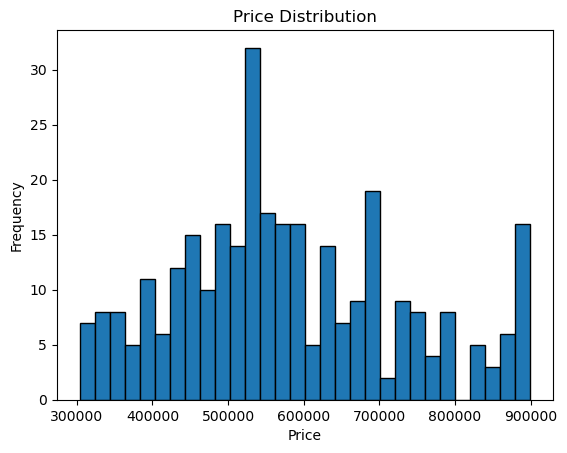

In [293]:
# Print out the spread of prices using matplotlib
# Assuming df['prices'] contains your price data
plt.hist(data['price'], bins=30, edgecolor='black')
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

### Merge bathroom, bedroom, frontal, and kitchen into one image

In [294]:
images_output=[]
img_df = img
for row_index,row in img.iterrows():
    # Check if the row_index is in the outliers to do this do the outliers first
    if row_index in outliers: 
      img_df = img_df[img_df.index != row_index] # Remove outlier
      # print(img_df.shape)
      continue

    inputImages=[]
    outputImage = np.zeros((128, 128, 3), dtype="uint8")
    image_temp1 = cv2.imread(row.bathroom_img)
    image1 = cv2.resize(image_temp1, (64 , 64))
            
    image_temp2 = cv2.imread(row.bedroom_img)
    image2 = cv2.resize(image_temp2, (64 , 64))
            
    image_temp3 = cv2.imread(row.frontal_img)
    image3 = cv2.resize(image_temp3, (64 , 64))
            
    image_temp4 = cv2.imread(row.kitchen_img)
    image4 = cv2.resize(image_temp4, (64 , 64))
              
    inputImages.append(image1)
    inputImages.append(image2)
    inputImages.append(image3)
    inputImages.append(image4)
            
    outputImage[0:64, 0:64] = inputImages[0]
    outputImage[0:64, 64:128] = inputImages[1]
    outputImage[64:128, 64:128] = inputImages[2]
    outputImage[64:128, 0:64] = inputImages[3]
            
    images_output.append(outputImage)      
            

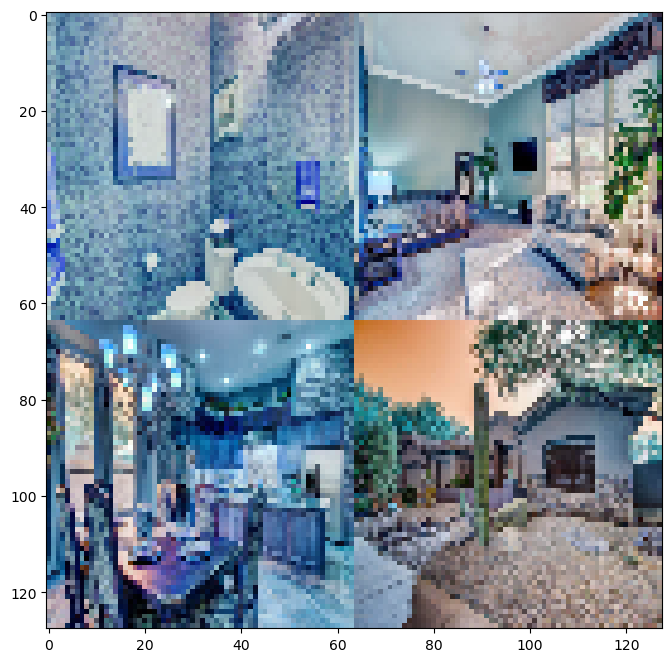

In [295]:
plt.figure(figsize=(8,8))
plt.imshow(images_output[0], interpolation='nearest')
plt.show()


### Check if same outliers are removed from both img and textual tables

In [298]:
# All the images match
value = data[img_df.index == data.index]
value.shape

(308, 5)

### Normalize Textual Data and Image Data

In [299]:
data_formatted = pd.get_dummies(data, columns=['zipcode'])

In [300]:
data_formatted.shape

(308, 36)

In [301]:
data_formatted.head()

,Bedrooms,Bathrooms,area,price,zipcode_36372,zipcode_60002,zipcode_62025,zipcode_62249,zipcode_81418,zipcode_81524,...,zipcode_93314,zipcode_93446,zipcode_93510,zipcode_94501,zipcode_94531,zipcode_94565,zipcode_94568,zipcode_95220,zipcode_96019,zipcode_98021
0,4,4.0,4053,869500,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,4,3.0,3343,865200,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,3,4.0,3923,889000,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6,3,4.0,2544,799000,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
10,5,5.0,4829,519200,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [302]:
# Normalize bedrooms & bathrooms & area
encode_numeric_zscore(data_formatted, 'Bedrooms')
encode_numeric_zscore(data_formatted, 'Bathrooms')
encode_numeric_zscore(data_formatted, 'area')

In [303]:
print(data_formatted['price'].dtype)

data_formatted['price'] = data_formatted['price'].astype("float32")

print(data_formatted['price'].dtype)


int64
float32


In [304]:
data_formatted['price'] = data_formatted['price'] / 100000.0

In [305]:
data_formatted.head()

,Bedrooms,Bathrooms,area,price,zipcode_36372,zipcode_60002,zipcode_62025,zipcode_62249,zipcode_81418,zipcode_81524,...,zipcode_93314,zipcode_93446,zipcode_93510,zipcode_94501,zipcode_94531,zipcode_94565,zipcode_94568,zipcode_95220,zipcode_96019,zipcode_98021
0,0.314624,1.370138,1.352073,8.695,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,0.314624,0.301101,0.736224,8.652,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,-0.574404,1.370138,1.239312,8.890,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6,-0.574404,1.370138,0.043178,7.990,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
10,1.203651,2.439175,2.025169,5.192,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [306]:
# normalize image data
img_output_df = np.array(images_output).astype('float32')
img_output_df /= 255.0

## to_xy and Test/Train Split

In [307]:
# use to_xy to split the tabular data into x and y
x, y = to_xy(data_formatted, 'price')
print(x.shape, y.shape)

(308, 35) (308,)


In [308]:
y[:5]

array([8.695, 8.652, 8.89 , 7.99 , 5.192], dtype=float32)

In [309]:
x_train, x_test, y_train, y_test= train_test_split(x, y, test_size=.20, random_state = 42)

In [310]:
print("Train Sizes :", x_train.shape, y_train.shape)
print("Test Sizes :", x_test.shape, y_test.shape)

Train Sizes : (246, 35) (246,)
Test Sizes : (62, 35) (62,)


In [311]:
x_train_img, x_test_img = train_test_split(img_output_df, test_size=.20,
                                          random_state=42)

In [312]:
print("Train Sizes :", x_train_img.shape)
print("Test Sizes :", x_test_img.shape)

Train Sizes : (246, 128, 128, 3)
Test Sizes : (62, 128, 128, 3)


## Model Training

### Double Check Shapes and Import

In [313]:
print(f"x_train shape: {x_train.shape}")
print(f"x_train_img shape: {x_train_img.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"x_test_img shape: {x_test_img.shape}")
print()

print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (246, 35)
x_train_img shape: (246, 128, 128, 3)
x_test shape: (62, 35)
x_test_img shape: (62, 128, 128, 3)

y_train shape: (246,)
y_test shape: (62,)


In [279]:
# Considerations : Keras Tuner 

In [280]:
from keras.utils import plot_model
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras.layers import concatenate
from keras.optimizers import Adam, SGD

### Base Model (Only Textual Data)

In [314]:
filepath = './dnn/best_weights-base.keras'
checkpointer = ModelCheckpoint(filepath=filepath, verbose=0, save_best_only=True) 

adam_optimizer = Adam(learning_rate=0.02, beta_1=0.9, beta_2=0.999,epsilon=1e-07)
sgd_optimizer = SGD(learning_rate=0.00007, momentum=0.9, nesterov=True)
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=5,verbose=1, mode='auto')

model = Sequential()
model.add(Dense(32, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1))

# print(model.summary())
# plot_model(model, show_shapes=True)
model.compile(loss='mean_squared_error', optimizer=adam_optimizer)
model.fit(x_train, y_train, 
          validation_data=(x_test, y_test), 
          callbacks=[monitor, checkpointer],verbose=2,epochs=250)
  
print('Training model 1 finished...Loading the best model')
print()
model.load_weights(filepath) # load weights from best model

pred_base = model.predict(x_test)
score_base = np.sqrt(metrics.mean_squared_error(pred_base,y_test))
print("Score (RMSE): {}".format(score_base))

Epoch 1/250
8/8 - 2s - 254ms/step - loss: 32.4567 - val_loss: 24.5621
Epoch 2/250
8/8 - 0s - 13ms/step - loss: 14.3417 - val_loss: 6.8360
Epoch 3/250
8/8 - 0s - 13ms/step - loss: 4.6643 - val_loss: 6.3770
Epoch 4/250
8/8 - 0s - 13ms/step - loss: 2.6313 - val_loss: 3.3740
Epoch 5/250
8/8 - 0s - 13ms/step - loss: 2.0070 - val_loss: 2.3708
Epoch 6/250
8/8 - 0s - 26ms/step - loss: 1.4722 - val_loss: 2.0525
Epoch 7/250
8/8 - 0s - 19ms/step - loss: 1.3085 - val_loss: 1.9910
Epoch 8/250
8/8 - 0s - 15ms/step - loss: 1.1584 - val_loss: 1.8323
Epoch 9/250
8/8 - 0s - 14ms/step - loss: 1.1194 - val_loss: 1.6924
Epoch 10/250
8/8 - 0s - 13ms/step - loss: 1.0689 - val_loss: 1.6221
Epoch 11/250
8/8 - 0s - 10ms/step - loss: 1.0200 - val_loss: 1.6280
Epoch 12/250
8/8 - 0s - 13ms/step - loss: 0.9900 - val_loss: 1.5994
Epoch 13/250
8/8 - 0s - 13ms/step - loss: 0.9944 - val_loss: 1.5936
Epoch 14/250
8/8 - 0s - 13ms/step - loss: 0.9707 - val_loss: 1.5279
Epoch 15/250
8/8 - 0s - 10ms/step - loss: 0.9889 - va

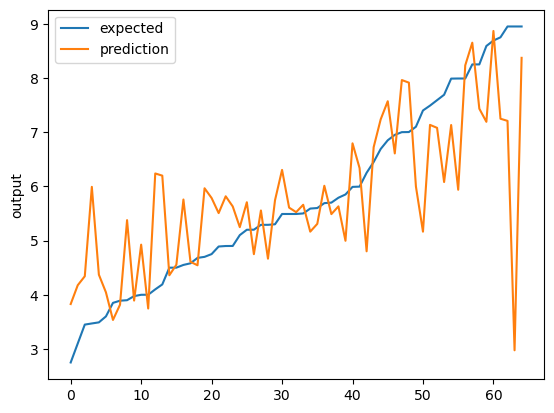

In [282]:
chart_regression(pred_base.flatten(),y_test)

### Model 2 : Conv2D and Dense

In [ ]:
filepath = './dnn/best_weights1.keras'
checkpointer = ModelCheckpoint(filepath=filepath, verbose=0, save_best_only=True) 

adam_optimizer = Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
sgd_optimizer = SGD(learning_rate=0.005, momentum=0.9, nesterov=True)


monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5,verbose=1, mode='auto')

# first image input model
visible1 = Input(shape=(128, 128, 3))
conv11 = Conv2D(32, kernel_size=4, activation='relu')(visible1)
pool11 = MaxPooling2D(pool_size=(2, 2))(conv11)
conv12 = Conv2D(64, kernel_size=4, activation='relu')(pool11)
pool12 = MaxPooling2D(pool_size=(2, 2))(conv12)
# conv13 = Conv2D(64, kernel_size=4, activation='relu')(pool12)
# pool13 = MaxPooling2D(pool_size=(2, 2))(conv13)
flat1 = Flatten()(pool12)

# Tabular data input model 
visible2 = Input(shape=(x.shape[1],))
dense1 = Dense(128, activation='relu')(visible2)
dense2 = Dense(64, activation='relu')(dense1)
dense3 = Dense(32, activation='relu')(dense2)

merge = concatenate([flat1, dense3])

# hidden1 = Dense(32, activation='relu')(merge)
# hidden2 = Dense(8, activation='relu')(hidden1)
# output = Dense(1)(hidden2)

output = Dense(1)(merge)

model = Model(inputs=[visible1, visible2], outputs=output)

# print(model.summary())
# plot_model(model, show_shapes=True)
model.compile(loss='mean_squared_error', optimizer=adam_optimizer)
model.fit([x_train_img, x_train], y_train, 
          validation_data=([x_test_img, x_test], y_test), 
          callbacks=[monitor, checkpointer],verbose=2,epochs=100)
  
print('Training model 1 finished...Loading the best model')
print()
model.load_weights(filepath) # load weights from best model

pred = model.predict([x_test_img, x_test])
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

Epoch 1/100
8/8 - 8s - 1s/step - loss: 233.8129 - val_loss: 38.1054
Epoch 2/100
8/8 - 4s - 453ms/step - loss: 35.3482 - val_loss: 34.5474
Epoch 3/100
8/8 - 4s - 482ms/step - loss: 27.9482 - val_loss: 16.9113
Epoch 4/100


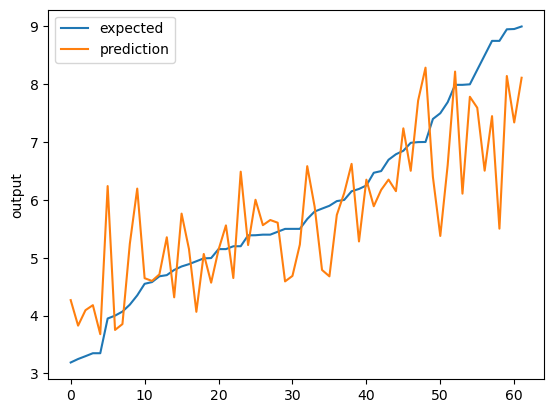

In [337]:
chart_regression(pred.flatten(),y_test)

In [332]:
filepath = './dnn/best_weights2.keras'
checkpointer = ModelCheckpoint(filepath=filepath, verbose=0, save_best_only=True) 

adam_optimizer = Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
sgd_optimizer = SGD(learning_rate=0.001, momentum=0.9, nesterov=True)


monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

      
# first image input model
visible1 = Input(shape=(128, 128, 3))
conv11 = Conv2D(32, kernel_size=4, activation='relu')(visible1)
pool11 = MaxPooling2D(pool_size=(2, 2))(conv11)
conv12 = Conv2D(64, kernel_size=4, activation='relu')(pool11)
pool12 = MaxPooling2D(pool_size=(2, 2))(conv12)
# conv13 = Conv2D(64, kernel_size=4, activation='relu')(pool12)
# pool13 = MaxPooling2D(pool_size=(2, 2))(conv13)
flat1 = Flatten()(pool12)

# Tabular data input model 
visible2 = Input(shape=(x.shape[1],))
dense1 = Dense(128, activation='relu')(visible2)
dense2 = Dense(64, activation='relu')(dense1)
dense2 = Dropout(.2)(dense2)
dense3 = Dense(32, activation='relu')(dense2)

merge = concatenate([flat1, dense3])

# hidden1 = Dense(32, activation='relu')(merge)
# hidden2 = Dense(8, activation='relu')(hidden1)
# output = Dense(1)(hidden2)
output = Dense(1)(merge)

model = Model(inputs=[visible1, visible2], outputs=output)

  # print(model.summary())
  # plot_model(model, show_shapes=True)
model.compile(loss='mean_squared_error', optimizer=adam_optimizer)
model.fit([x_train_img, x_train], y_train, 
           validation_data=([x_test_img, x_test], y_test), 
          callbacks=[monitor, checkpointer],verbose=2,epochs=100)
  
print('Training model 1 finished...Loading the best model')
print()
model.load_weights(filepath) # load weights from best model

pred2 = model.predict([x_test_img, x_test])
score2 = np.sqrt(metrics.mean_squared_error(pred2,y_test))
print("Score (RMSE): {}".format(score2))

Epoch 1/100
8/8 - 6s - 751ms/step - loss: 198.5274 - val_loss: 24.0745
Epoch 2/100
8/8 - 3s - 409ms/step - loss: 9.1340 - val_loss: 7.6860
Epoch 3/100
8/8 - 3s - 399ms/step - loss: 4.3475 - val_loss: 3.3121
Epoch 4/100
8/8 - 5s - 626ms/step - loss: 3.0787 - val_loss: 3.0947
Epoch 5/100
8/8 - 3s - 370ms/step - loss: 2.5827 - val_loss: 2.7679
Epoch 6/100
8/8 - 4s - 457ms/step - loss: 2.3030 - val_loss: 2.4547
Epoch 7/100
8/8 - 3s - 391ms/step - loss: 1.8556 - val_loss: 2.1201
Epoch 8/100
8/8 - 3s - 392ms/step - loss: 1.5333 - val_loss: 1.7803
Epoch 9/100
8/8 - 3s - 380ms/step - loss: 1.2164 - val_loss: 1.5043
Epoch 10/100
8/8 - 3s - 378ms/step - loss: 1.1938 - val_loss: 1.2259
Epoch 11/100
8/8 - 3s - 377ms/step - loss: 1.0413 - val_loss: 1.8659
Epoch 12/100
8/8 - 3s - 408ms/step - loss: 1.0414 - val_loss: 1.1380
Epoch 13/100
8/8 - 3s - 342ms/step - loss: 0.9927 - val_loss: 1.2282
Epoch 14/100
8/8 - 3s - 414ms/step - loss: 1.1277 - val_loss: 1.2366
Epoch 15/100
8/8 - 3s - 412ms/step - los

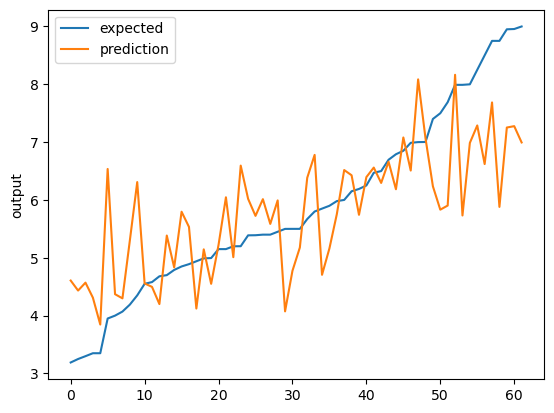

In [333]:
chart_regression(pred2.flatten(),y_test)

In [ ]:
# Transfer learning
from keras.applications.vgg16 import VGG16

filepath = './dnn/best_weights3.keras'
checkpointer = ModelCheckpoint(filepath=filepath, verbose=0, save_best_only=True) 

adam_optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
sgd_optimizer = SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

for i in range(0,1):
  print("=================== ", i)
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

  # Transfer - Learning : VGG 16
  vgg = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3)) 
  
  # Freeze the weights
  for layer in vgg.layers:
    layer.trainable = False

  vgg_out = Flatten()(vgg.output)
  visible1 = vgg.input

  # Tabular data input model 
  visible2 = Input(shape=(x.shape[1],))
  dense1 = Dense(128, activation='relu')(visible2)
  dense1 = Dropout(.5)(dense1)
  dense2 = Dense(64, activation='relu')(dense1)

  # dense3 = Dense(32, activation='relu')(dense2)

  merge = concatenate([vgg_out, dense2])

  hidden1 = Dense(32, activation='relu')(merge)
  hidden2 = Dense(16, activation='relu')(hidden1)
  output = Dense(1)(hidden2)

  model = Model(inputs=[visible1, visible2], outputs=output)

  # print(model.summary())
  model.compile(loss='mean_squared_error', optimizer=adam_optimizer)
  model.fit([x_train_img, x_train], y_train, 
            validation_data=([x_test_img, x_test], y_test), 
          callbacks=[monitor, checkpointer],verbose=2,epochs=100)
  
print('Training finished...Loading the best model')
print()
model.load_weights(filepath) # load weights from best model

pred3 = model.predict([x_test_img, x_test])
score3 = np.sqrt(metrics.mean_squared_error(pred3,y_test))
print("Score (RMSE): {}".format(score3))

In [ ]:
chart_regression(pred3.flatten(),y_test)